# Beehive monitoring

William Albert, Hannah Weiser, Ronald Tabernig, July 2025 

This notebook demonstrates the preparation of the beehive monitoring example, including the bee detection workflow. The dataset contains **6 scans** of a beehive and the surrounding, each captured every 40 seconds on 14 May 2025.

For our use case, a point cloud **mask** was created containing the background points, i.e., all points not reflected from the flying bees. To speed up processing, the background points in each epoch were thinned using spatial subsampling (0.01 m), while the bee points were kept at their original resolution.

## Imports

In [1]:
import vapc
import numpy as np
import os
import sys
import json
sys.path.insert(0, "../src")
from fourdgeo import projection
from fourdgeo import utilities

# File import and handling
from pathlib import Path
import zipfile, urllib.request, shutil
from glob import glob

# Clustering
from sklearn.cluster import DBSCAN

# Image handling
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageFont
from IPython.display import HTML
from shapely.geometry import shape

vapc.enable_trace(False)
vapc.enable_timeit(False)

## Get the data

In [2]:
# Handle file download/reading here
data_url = "https://heibox.uni-heidelberg.de/f/0ecf5340ade347548877/?dl=1"
file_name = "beehive.zip"
data_folder = "data/beehive"

if not Path(data_folder).exists():
    with urllib.request.urlopen(data_url) as response, open(file_name, 'wb') as out_file:
        shutil.copyfileobj(response, out_file)
    with zipfile.ZipFile(file_name, 'r') as zip_ref:
        zip_ref.extractall(data_folder)
    
    # Deleting the .zip file
    os.remove(file_name)

## Bee detection

For the bee detection, we first isolate the bees from the rest of the scene by masking the trees, beehive, ground, etc. using the provided point cloud mask (`mask.laz`). Then, we cluster the bee points using [DBSCAN](https://www.dbs.ifi.lmu.de/Publikationen/Papers/KDD-96.final.frame.pdf) and write out the clustered point clouds.

In [3]:
observations = {"observations": []}
cluster_files = []

# Gather & sort only the .laz files
laz_paths = list(Path(data_folder).glob("*[!k].laz")) # Get all the files except the mask
laz_paths = sorted(laz_paths)

voxel_size = 0.05

dh_mask = vapc.DataHandler(Path(data_folder) / "mask.laz")
dh_mask.load_las_files()

vp_mask = vapc.Vapc(voxel_size=voxel_size, return_at="center_of_voxel")
vp_mask.get_data_from_data_handler(dh_mask)
vp_mask.voxel_index = False

for epoch_id, laz_path in enumerate(laz_paths):
    dh_epoch = vapc.DataHandler(laz_path)
    dh_epoch.load_las_files()
    dh_epoch.df = dh_epoch.df.loc[:, ['X','Y','Z','intensity','gps_time']]  # Only keeping xyz, intensity and GPS time

    ## 1. Isolate the bees
    vp_epoch = vapc.Vapc(voxel_size=voxel_size, return_at="center_of_voxel")
    vp_epoch.get_data_from_data_handler(dh_epoch)
    vp_epoch.select_by_mask(vp_mask, segment_in_or_out="out")    # <-- select_by_mask "out"
    dh_epoch.df = vp_epoch.df

    masked_pc_path = os.path.join(f"out/beehive/masked_{epoch_id:02d}_vox_{int(voxel_size*1000):03d}.laz")
    dh_epoch.save_as_las(masked_pc_path)

    ## 2. Spatial clustering
    coords = dh_epoch.df[["X", "Y", "Z"]].to_numpy()
    clustering = DBSCAN(eps=0.1, min_samples=4).fit(coords)
    cluster = clustering.labels_
    dh_epoch.df["cluster"] = cluster
    dh_epoch.df = dh_epoch.df[dh_epoch.df.cluster != -1]    # Dropping the points with a cluster value of -1
    outfile = masked_pc_path.replace(".laz", "_clustered.laz")
    dh_epoch.save_as_las(outfile)
    cluster_files.append(outfile)

## Projections (background point cloud)
### Prepare the configuration file

We use a configuration dictionary that contains general project settings like the `output_folder` and the relevant settings for the point cloud projection. For the projection, parameters like the `camera_position` and the `resolution_cm` are essential.

In [4]:
configuration = {
    "project_setting": {
        "project_name": "Beehive",
        "output_folder": "./out/beehive",
        "temporal_format": "%y%m%d_%H%M%S",
        "silent_mode": True,
        "include_timestamp": False
    },
    "pc_projection": {
        "pc_path": "",
        "make_range_image": True,
        "make_color_image": False,
        "top_view": False,
        "save_rot_pc": False,
        "resolution_cm": 0.5,
        "camera_position": [
            0.0,
            0.0,
            0.0
        ],
        "rgb_light_intensity": 100,
        "range_light_intensity": 10,
        "epsg": None
    }
}

### Generate the background image

We now generate the background image. For this, we are using classes and functions from the `fourdgeo` library. The class `PCloudProjection` directly takes our configuration file as input and writes the generated image to our specified `output_folder`.

In [5]:
pc = laz_paths[0]

dh_epoch = vapc.DataHandler(pc)
dh_epoch.load_las_files()

# Get the background scene
vp_epoch = vapc.Vapc(voxel_size=voxel_size)
vp_epoch.get_data_from_data_handler(dh_epoch)
vp_epoch.select_by_mask(vp_mask, segment_in_or_out="in")    # <-- select_by_mask "in"
dh_epoch.df = vp_epoch.df

bg_pc_path = os.path.join(f"out/beehive/background_pc.laz")
dh_epoch.save_as_las(bg_pc_path)

configuration['pc_projection']['pc_path'] = bg_pc_path
project_name = configuration['project_setting']['project_name']
output_folder = configuration['project_setting']['output_folder']

background_projection = projection.PCloudProjection(
    configuration = configuration,
    project_name = project_name,
    projected_image_folder = output_folder,
)
(
    ref_h_fov, ref_v_fov, ref_anchor_point_xyz, 
    ref_h_img_res, ref_v_img_res
) = background_projection.project_pc(buffer_m = 0.25)

bg_img = background_projection.bg_image_filename[0]

D:\Software\micromamba\envs\vapc\lib\site-packages\rasterio\__init__.py:378: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = writer(


### Dispay the background image

Let's have a look at how the point cloud looks like from the scanner view.

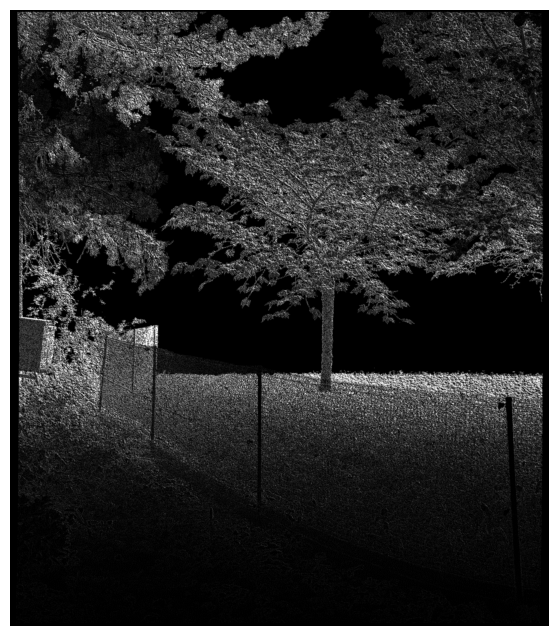

In [6]:
img_path = r"../docs/out/beehive/Beehive_RangeImage.tif"

# Load and display TIFF image
img = Image.open(img_path)
plt.figure(figsize=(12, 8))
plt.imshow(img)
plt.axis('off')
plt.show()

## Projections (bee observations)

We describe each bee cluster by its centroid. In the following, we extract the center point for each center and create `geoObjects`, one for each cluster.

In [7]:
for epoch_id, cluster_file in enumerate(cluster_files):
    geoObjects = []
    dh_cluster = vapc.DataHandler(cluster_file)
    dh_cluster.load_las_files()

    # get cluster center from each cluster (each bee)
    cluster_centers = dh_cluster.df.groupby('cluster').mean().reset_index().to_numpy()
    columns = dh_cluster.df.groupby('cluster').mean().reset_index().columns
    cluster_idx = columns.get_loc('cluster')
    intensity_idx = columns.get_loc('intensity')
    gps_time_idx = columns.get_loc('gps_time')

    # extract time from filename
    t_min = t_max = utilities.iso_timestamp(laz_path.stem.split(" ")[-3])

    # create json object for each line
    for i, cluster_center in enumerate(cluster_centers):
        geoObject = {}
        geoObject["id"] = f"{epoch_id}{i:04d}"
        geoObject["type"] = "point"
        geoObject["dateTime"] = t_min
        geoObject["geometry"] = {
            "type": "",
            "coordinates": [
                cluster_center[1:4].tolist()
            ]
        }
        geoObject["customEntityData"] = {
            "cluster_id":  cluster_center[cluster_idx],
            "intensity": cluster_center[intensity_idx],
            "gps_time": cluster_center[gps_time_idx],
            "epoch_id": epoch_id
        }
        
        geoObjects.append(geoObject)

    observations["observations"].append({
        "startDateTime": t_min,
        "endDateTime": t_max,
        "geoObjects": geoObjects,
        "backgroundImageData": {
            "url": bg_img,
            "height": Image.open(bg_img).convert("RGB").size[1],
            "width": Image.open(bg_img).convert("RGB").size[0]
        },
    })

### Project the bee clusters onto the image background

Here, we project the bee observations onto the background image using the `ProjectChange` class. The `observation` GeoJSON files are written to the `output_folder`.

In [8]:
from fourdgeo import projection
list_observation_projection = []
for epoch_id, observation in enumerate(observations['observations']):
    observation_projection = projection.ProjectChange(observation=observation,
                            project_name=f"{project_name}_{epoch_id}_{epoch_id+1}",
                            projected_image_path=background_projection.bg_image_filename[0],
                            projected_events_folder=output_folder,
                            epsg=None)

    observation_projection.project_change()
    list_observation_projection.append(observation_projection)

D:\Software\micromamba\envs\vapc\lib\site-packages\rasterio\__init__.py:368: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


### Display the bee clusters in the site

Finally, we generate a GIF of the time series and display the bee clusters using the projected points.

In [9]:
frames = []
gif_path = "../docs/img/beehive_projections_plus_observations.gif"
font = ImageFont.load_default(size = 50)
ellipse_size = 8

for enum, observation_projection in enumerate(list_observation_projection):
    frm = Image.open(bg_img).convert("RGB")
    draw = ImageDraw.Draw(frm)
    draw.text((50, 1300), f"Epoch: {enum}", fill=(255, 255, 255), font=font)

    # Load geojson
    with open(observation_projection.geojson_name, 'r') as f:
        geojson_data = json.load(f)

    for feature in geojson_data["features"]:
        geom = shape(feature["geometry"])
        
        coords = [(int(x), -int(y)) for x, y in geom.coords]

        x, y = geom.coords[0][0], geom.coords[0][1] * -1
        draw.ellipse([x-ellipse_size//2, y-ellipse_size//2, x+ellipse_size//2, y+ellipse_size//2], fill="yellow")

    frames.append(frm)
    

frames[0].save(
    gif_path,
    save_all=True,
    append_images=frames[1:],
    duration=600,
    loop=0
)

![beehive_projections_plus_observations.gif](img/beehive_projections_plus_observations.gif)